In [9]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt

In [2]:
# Load datasets
customers_data = pd.read_csv(r"./dataset/Customers.csv")
products_data = pd.read_csv(r"./dataset/Products.csv")
transactions_data = pd.read_csv(r"./dataset/Transactions.csv")

In [3]:
# Display basic info about the datasets to understand their structure
customers_info = customers_data.info(), customers_data.head()
products_info = products_data.info(), products_data.head()
transactions_info = transactions_data.info(), transactions_data.head()

customers_info, products_info, transactions_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  


((None,
    CustomerID        CustomerName         Region  SignupDate
  0      C0001    Lawrence Carroll  South America  2022-07-10
  1      C0002      Elizabeth Lutz           Asia  2022-02-13
  2      C0003      Michael Rivera  South America  2024-03-07
  3      C0004  Kathleen Rodriguez  South America  2022-10-09
  4      C0005         Laura Weber           Asia  2022-08-15),
 (None,
    ProductID              ProductName     Category   Price
  0      P001     ActiveWear Biography        Books  169.30
  1      P002    ActiveWear Smartwatch  Electronics  346.30
  2      P003  ComfortLiving Biography        Books   44.12
  3      P004            BookWorld Rug   Home Decor   95.69
  4      P005          TechPro T-Shirt     Clothing  429.31),
 (None,
    TransactionID CustomerID ProductID      TransactionDate  Quantity  \
  0        T00001      C0199      P067  2024-08-25 12:38:23         1   
  1        T00112      C0146      P067  2024-05-27 22:23:54         1   
  2        T00166    

In [4]:
# Aggregating transaction data to derive customer-level metrics
customer_transaction_summary = transactions_data.groupby("CustomerID").agg(
    TotalTransactions=("TransactionID", "count"),  # Total number of transactions
    TotalQuantity=("Quantity", "sum"),            # Total quantity purchased
    TotalSpent=("TotalValue", "sum"),             # Total money spent
    AverageOrderValue=("TotalValue", "mean"),     # Average transaction value
).reset_index()

In [5]:
# Merge with customer profile data
customer_data = pd.merge(customers_data, customer_transaction_summary, on="CustomerID", how="left")

# Fill missing values for customers with no transactions
customer_data.fillna({
    "TotalTransactions": 0,
    "TotalQuantity": 0,
    "TotalSpent": 0.0,
    "AverageOrderValue": 0.0
}, inplace=True)

In [6]:
customer_data.head()

,CustomerID,CustomerName,Region,SignupDate,TotalTransactions,TotalQuantity,TotalSpent,AverageOrderValue
0,C0001,Lawrence Carroll,South America,2022-07-10,5.0,12.0,3354.52,670.904
1,C0002,Elizabeth Lutz,Asia,2022-02-13,4.0,10.0,1862.74,465.685
2,C0003,Michael Rivera,South America,2024-03-07,4.0,14.0,2725.38,681.345
3,C0004,Kathleen Rodriguez,South America,2022-10-09,8.0,23.0,5354.88,669.360
4,C0005,Laura Weber,Asia,2022-08-15,3.0,7.0,2034.24,678.080


In [8]:
# Select relevant features for clustering
features = ["TotalTransactions", "TotalQuantity", "TotalSpent", "AverageOrderValue"]

# Normalize the features
scaler = StandardScaler()
customer_data_scaled = customer_data.copy()
customer_data_scaled[features] = scaler.fit_transform(customer_data[features])

# Preview the normalized dataset
customer_data_scaled[features].head()

,TotalTransactions,TotalQuantity,TotalSpent,AverageOrderValue
0,0.000000,-0.110735,-0.051884,-0.054781
1,-0.451294,-0.434049,-0.862714,-0.903985
2,-0.451294,0.212579,-0.393842,-0.011575
3,1.353881,1.667493,1.035375,-0.061170
4,-0.902587,-0.919021,-0.769499,-0.025086


In [10]:
# Apply K-Means clustering
num_clusters = 4  # Initial guess for clusters; can experiment with other numbers
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
customer_data_scaled["Cluster"] = kmeans.fit_predict(customer_data_scaled[features])

In [11]:
# Evaluate clustering using Davies-Bouldin Index
db_index = davies_bouldin_score(customer_data_scaled[features], customer_data_scaled["Cluster"])

# Visualize clusters using a 2D PCA reduction
from sklearn.decomposition import PCA

In [12]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(customer_data_scaled[features])
customer_data_scaled["PCA1"] = reduced_data[:, 0]
customer_data_scaled["PCA2"] = reduced_data[:, 1]

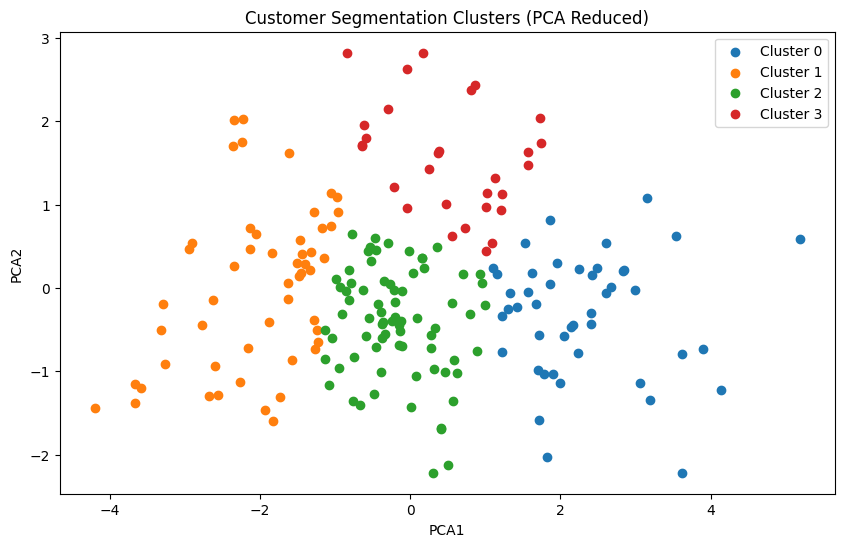

0.9322574305812845

In [13]:
# Plot the clusters
plt.figure(figsize=(10, 6))
for cluster in range(num_clusters):
    cluster_data = customer_data_scaled[customer_data_scaled["Cluster"] == cluster]
    plt.scatter(cluster_data["PCA1"], cluster_data["PCA2"], label=f"Cluster {cluster}")
plt.title("Customer Segmentation Clusters (PCA Reduced)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()
plt.show()

db_index